In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Model "Majority rule" from the paper 

In [16]:
n = 4 # Dimension of the model

q=10
lamb=1


def computeK(m):
    K = np.zeros(shape=(n,n))
    K[0,1] = 1/q;                     K[0,0] = 1-K[0,1]
    K[1,0] = 3/q*(m[1]**2+m[1]*m[3]);
    K[1,2] = 3/q*m[3]**2
    K[1,1] = 1-K[1,0]-K[1,2]
    K[2,3] = lamb/q;                  K[2,2] = 1-K[2,3]
    K[3,0] = 3/q*m[1]**2;
    K[3,2] = 3/q*(m[3]**2+m[1]*m[3])
    K[3,3] = 1-K[3,2]-K[3,0]
    for i in range(n):
        for j in range(n):
            if K[i,j] < 0 or K[i,j] > 1: 
                print('rate error: K[',i,j,']=',K[i,j])
    return(K)

m0 = np.array([0.6,0,0.4,0])

def simulate(m0,T):
    m=m0
    M=np.zeros(shape=(T,n))
    for t in range(T):
        m = np.tensordot(m,computeK(m),1)
        M[t,:] = m
    return(M)



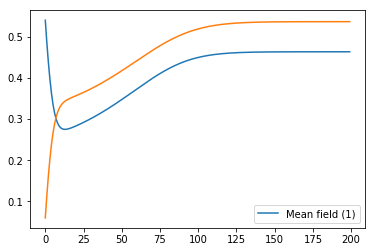

In [17]:
mf = simulate(m0,200)
plt.plot(mf[:,0:2])
plt.legend(['Mean field (1)'])

# Refined mean field 

In [25]:
def computeA(m):
    JNA = 1-(9/q*m[1]**2+6/q*m[1]*m[3]+3/q*m[3]**2)
    JNB = 1-(3/q*m[1]**2+9/q*m[3]**2+6/q*m[1]*m[3])
    return(np.array([
        [1-1/q, 9/q*m[1]**2+12/q*m[1]*m[3], 0, 6/q*m[1]**2],
        [1/q,    JNA,    0, -3/q*m[1]**2-6/q*m[1]*m[3]],
        [0, 6/q*m[3]**2, 1-lamb/q, 12/q*m[1]*m[3]+9/q*m[3]**2],
        [0, -3/q*m[3]**2 - 6/q * m[1]*m[3], lamb/q, JNB]
    ]))

def computeB(m):
    B = np.zeros(shape=(n,n,n))
    B[0,:,:] = np.array([[0,0,0,0],[0,18/q*m[1]+12/q*m[3],0,12/q*m[1]],
                        [0,0,0,0],[0,12/q*m[1],0,0]])
    B[1,:,:] = np.array([[0,0,0,0],[0,-18/q*m[1]-6/q*m[3],0,-6/q*m[1]-6/q*m[3]],
                        [0,0,0,0],[0,-6/q*m[1]-6/q*m[3],0,-6/q*m[1]]])
    B[2,:,:] = np.array([[0,0,0,0],[0,0,0,12/q*m[3]],[0,0,0,0],[0,12/q*m[3],0,18/q*m[3]+12/q*m[1]]])
    B[3,:,:] = np.array([[0,0,0,0],[0,-6/q*m[3],0,-6/q*m[1]]-6/q*m[3],
                        [0,0,0,0],[0,-6/q*m[1]-6/q*m[3],0,-18/q*m[3]-6/q*m[1]]])
    
    return(B)
def computeGamma(m):
    G = np.zeros(shape=(n,n))
    K = computeK(m)
    for j in range(n):
        for k in range(n):
            if j==k: 
                G[j,k] = sum([m[i]*K[i,j]*(1-K[i,j]) for i in range(n)])
            else:
                G[j,k] = sum([m[i]*K[i,j]*(-K[i,k]) for i in range(n)])
    return(G)

def refinedMF(m0,T):
    m = m0
    v = np.zeros((n))
    w = np.zeros((n,n))
    
    M=[]
    V=[]
    W=[]
    
    for t in range(T):
        A = computeA(m)
        B = computeB(m)
        Gamma = computeGamma(m)
        
        M.append(m)
        
        v = np.dot(A,v) + np.tensordot(B,w,2)/2
        w = Gamma + np.dot(np.dot(A,w),np.transpose(A))
        m = np.tensordot(m,computeK(m),1)
        
        V.append(v)
        W.append(w)
        
    return(np.array(M),np.array(V),np.array(W))

M,V,W = refinedMF(m0,200)


# Comparison with simulation

In [56]:
import os 
import sys
import time

def simulate_MC(m0,T,N):
    m = np.array([int(N*m0[i]) for i in range(n)])
    M = []
    
    for t in range(T):
        M.append(m)
        K = computeK(m*1./N)
        newM = np.zeros(n)
        for i in range(n):
            newM += np.random.multinomial(m[i], K[i,:], size=1).reshape(n)
        m = newM
    return(np.array(M)*1./N)

def averageSimulation(m0,T,N,number_of_simulations,forceRedoSimulation=False):
    fileName = 'traj/simu_MajRule_m{}_{}_{}_{}_N{}_T{}.npz'.format(int(m0[0]*1000),
                                                           int(m0[1]*1000),
                                                           int(m0[2]*1000),
                                                           int(m0[3]*1000),
                                                           N,
                                                           T)
    if os.path.isfile(fileName) and not forceRedoSimulation :
        data = np.load(fileName)
        alreadyDoneSimu = data['nbSimu']
        M = data['M']
    else:
        alreadyDoneSimu = 0
        M = np.zeros(shape=(T,len(m0)))
    if alreadyDoneSimu < number_of_simulations:
        for i in range(alreadyDoneSimu,number_of_simulations):
            sampleM = simulate_MC(m0,T,N)
            M += sampleM
            print('\r{}/{}'.format(i,number_of_simulations),end='')
        np.savez(fileName,M=M,nbSimu=number_of_simulations)
    return(M/max(alreadyDoneSimu,number_of_simulations))

#m0 = np.array([1,0,0,0])
m0 = np.array([0.6,0.,0.4,0.])

for numberSimu in range(0,10000,1000):
    for N in [32,160]:
        # This code will generate 50000 simulation and saves the result each 5000 simulation (hence it can be interupted)
        Msimu = averageSimulation(m0,T=200,N=N,number_of_simulations=numberSimu)

8999/9000

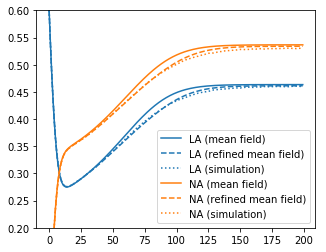

In [69]:
f = plt.figure()
f.set_size_inches(5,4)
N=160
mf = simulate(m0,200)
rmf = M+V/N
Msimu = averageSimulation(m0,T=200,N=N,number_of_simulations=numberSimu)
for i in range(2):
    plt.plot(M[:,i],color='C{}'.format(i))
    plt.plot(rmf[:,i],'--',color='C{}'.format(i))
    plt.plot(Msimu[:,i],':',color='C{}'.format(i))
plt.ylim([0.2,0.6])
plt.legend(['LA (mean field)','LA (refined mean field)','LA (simulation)',
            'NA (mean field)','NA (refined mean field)',
           'NA (simulation)'])
f.savefig('output_pdfs/MajorityRule_LANA_N{}.pdf'.format(N),bbox_inches='tight')

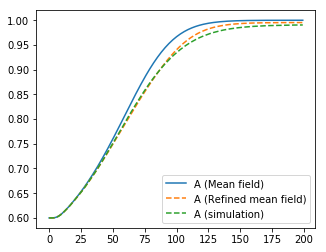

In [70]:
f = plt.figure()
N=160
f.set_size_inches(5,4)
mf = simulate(m0,200)
rmf = M+V/N
Msimu = averageSimulation(m0,T=200,N=N,number_of_simulations=numberSimu)
plt.plot(np.sum(M[:,0:2],1))
plt.plot(np.sum(rmf[:,0:2],1),'--')
plt.plot(np.sum(Msimu[:,0:2],1),'--')
#plt.ylim([0.2,0.6])
plt.legend(['A (Mean field)','A (Refined mean field)','A (simulation)'])
f.savefig('output_pdfs/MajorityRule_A_N{}.pdf'.format(N),bbox_inches='tight')

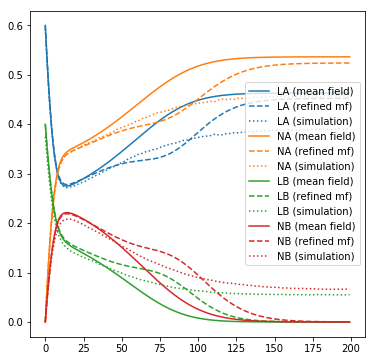

In [68]:
f = plt.figure()
f.set_size_inches(6,6)
N=32
Msimu = averageSimulation(m0,T=200,N=N,number_of_simulations=numberSimu)
mf = simulate(m0,200)
rmf = M+V/N
for i in range(4):
    plt.plot(M[:,i],color='C{}'.format(i))
    plt.plot(rmf[:,i],'--',color='C{}'.format(i))
    plt.plot(Msimu[:,i],':',color='C{}'.format(i))
#plt.ylim([0.2,0.6])
plt.legend(['LA (mean field)', 'LA (refined mf)','LA (simulation)',
            'NA (mean field)', 'NA (refined mf)','NA (simulation)',
            'LB (mean field)', 'LB (refined mf)','LB (simulation)',
            'NB (mean field)', 'NB (refined mf)','NB (simulation)'
            ])
plt.xlabel('Time $t$')
plt.ylabel('$M$ or $m$')
f.savefig('output_pdfs/MajorityRule_all_N{}.pdf'.format(N),bbox_inches='tight')